In [1]:
#Parametrized Central Force Problem Errors, distances in m. Updating code for 2 body problem involves simply adding eulers to 
#earth paramters as well.

import numpy as np
import math
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["font.size"] = 14

In [2]:
######## Now defining force eqns. Gravitational forces reflect accelerations in meters / time
#must find reasonable t steps in eulers. for earth moon, i probably want mins, 2332800 t steps is approximately one period in s
# 648 t steps being one period would be steps of one hour

def x_force(xm, ym, xe=0, ye=0): #d^2x / dt^2 = return
    
    deltax = xm - xe
    deltay = ym - ye
    
    r = [deltax,deltay] #distance between them. used to detect collisions
    h = np.linalg.norm(r)

    cos = deltax / h
#    sin = deltay / h
    
    return -cos * (G*m2/(h**2))

def y_force(xm, ym, xe=0, ye=0): #d^2y / dt^2 = return
    
    deltax = xm - xe
    deltay = ym - ye
    
    r = [deltax,deltay] #distance between them. used to detect collisions
    h = np.linalg.norm(r)

 #   cos = deltax / h
    sin = deltay / h
    
    return -sin * (G*m2/(h**2))

def getL(m, x, y, vx, vy):
    return m * np.cross(np.array([x,y]),np.array([vx, vy]))

def getE(m, vx, vy, r):
    return (0.5 * m * ((np.linalg.norm([vx, vy]))**2)) - (m * m2 * G / r)

def Euler(vel, timestep, isX, xm, ym, xe=0, ye=0): #velocity of component = previous velocity + time step * (xforce or yforce)
    
    if (isX):
        return vel + timestep * x_force(xm, ym, xe, ye)
    
    else:
        return vel + timestep * y_force(xm, ym, xe, ye)

In [3]:
#########Now for numerically finding changes in parameters over time #############


def map_trajectory_parameters(method,t, step, xm, ym,tmax=3e6,v= None):
    
    t = 0 #initialize passing of time

    #instantiate lists of:
    #positions
    xx = [xm]
    yy =[ym]

    #radii
    r_exp = [np.linalg.norm([xm,ym])]

    #velocities
    if v is None:
        v = np.array([0, np.sqrt( (G * m2) / r_exp[0]  )])
    vel_x = [v[0]]
    vel_y = [v[1]]
    


    #ang momentum
    L_exp = [getL(m1, xm, ym, vel_x[-1], vel_y[-1])]
    #L_exp = [m1 * np.cross([xm,ym],[vel_x[-1], vel_y[-1]])]

    #total energy
    #E_exp = [(0.5 * m1 * ((np.linalg.norm([vel_x[-1], vel_y[-1]]))**2)) - (m1 * G / r_exp[-1])]
    E_exp = [getE(m1, vel_x[-1], vel_y[-1], r_exp[-1])]
    
    if (method == 'Euler'):
        #Euler_method()
        while (t < tmax): #should be enough to get one period if time steps is in s

            #update velocities
            vel_x.append(Euler(vel_x[-1], step, True,  xx[-1], yy[-1]))
            vel_y.append(Euler(vel_y[-1], step, False, xx[-1], yy[-1]))

            #update positions
            xx.append(xx[-1] + vel_x[-1]*step)
            yy.append(yy[-1] + vel_y[-1]*step)

            #update radius
            r = [xx[-1] - xe, yy[-1] - ye]
            r_exp.append(np.linalg.norm(r))

            #update ang momentum
            L_exp.append ( getL(m1,xx[-1],yy[-1],vel_x[-1],vel_y[-1]) )

            #update total energy
            E_exp.append ( getE( m1, vel_x[-1], vel_y[-1] , r_exp[-1] ))


            t = t + step #steps of 1 takes too long just to test the code

            #pos1 = np.array([xm,ym])
            #print(pos1[0], ' , ', pos1[1])
            #print()
        
    return (xx, yy, vel_x, vel_y, L_exp, E_exp, step)

#map_trajectory_parameters(0, step, xm, ym)

In [4]:
########### Now finding the errors for all parameters *********
tmax = 6e7#common simulation end time
step0 = 2**11 #.01 percent of moon's orbital period
stepmax = 2**18
G = 6.6743e-11 #gravitational constant

######## moon parameters and I.C.s ########
m1 = 0.07346e24 #moon mass in kg
pos1 = np.array([-3.84402e8,0]) #these are the initial conditions for x, y positions
r1 = 1738.1e3 #radius in m

######## earth parameters and I.C.s ########

m2 = 5.97219e24 #earth mass in kg
pos2 = np.array([0,0])
r2 = 6378e3 #radius in m

##### parameters including both bodies

xm = pos1[0] #rephrasing initial conditions of moon's position into x and y
ym = pos1[1]

xe = pos2[0] #rephrasing initial conditions of earth's position into x and y
ye = pos2[1]

#initial velocity of moon found from centripetal acc = Fg
#v = np.array([0, ( (G * m2) / np.linalg.norm(r) )**(1/2)]) #this is in m/s, about 1018.30259503 as the IC
#v0 = 1018.30259503 #magnitude of initial velocity


r_theo = np.linalg.norm([xm, ym])#3.84402e8
v_theo = 1018.30259503

#L_theo = 3.84402e8 * m1 * ( (G * m2) / (-3.84402e8) )**(1/2) #ang momentum: mvr for perfect circular motion
L_theo = ( m1 * np.cross([xm,ym],[0, v_theo]))

E_theo = (0.5 * m1 * ((3.84402e8)**2)) + (m1 * G * r_theo)#total energy = KE + U 
#for CFP this is constant and is only energy of moon which has all of systems energy

#initial empty arrays
errors = []

testx = []
testy = []

step = step0

method = 'Euler'


while ( step < stepmax +1 ):
    xms, yms, vxs, vys, Ls, Es, time_step = map_trajectory_parameters(method, 0, step, xm, ym,tmax)

    lastx = xms[-1]
    lasty = yms[-1]
    lastvx = vxs[-1]
    lastvy = vys[-1]
    lastL = Ls[-1]
    lastE = Es[-1]

    if (step == step0):
        testx = xms
        testy = yms

    pos_err =  abs( r_theo - np.linalg.norm([lastx, lasty]) )/r_theo
    vel_err =  abs( np.linalg.norm([vxs[0], vys[0]]) - np.linalg.norm([lastvx, lastvy]) )/np.linalg.norm([vxs[0], vys[0]])
    L_err =  abs( (Ls[0] - Ls[-1] )/Ls[0] )
    E_err =  abs( (Es[0] - Es[-1] )/Es[0] )

    errors.append([pos_err, vel_err, L_err, E_err, step])

    step = step*1.05

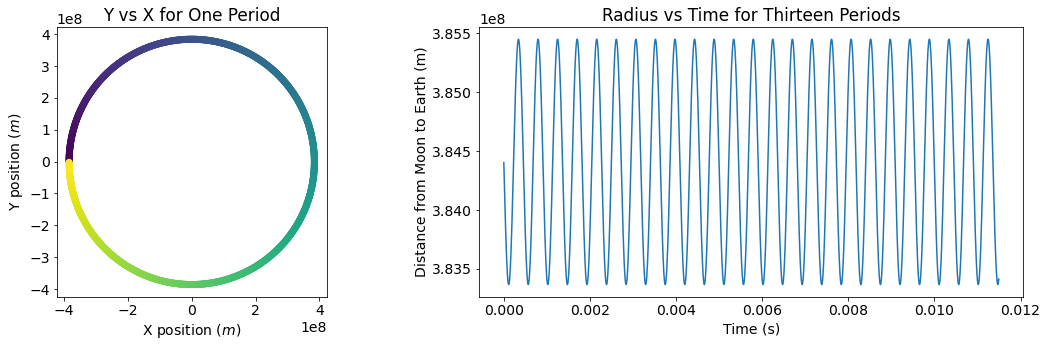

In [5]:
#fig = plt.figure(figsize=(15, 15))
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
#ax3 = fig.add_subplot(2,2,3)
#ax4 = fig.add_subplot(2,2,4)

T = 2548800

allts = []
for i in range(len(testx)):
    allts.append((1) * i)
    
allts = np.array(allts) / T

#c2 = np.linspace(-1, 1, len(testx) * (1/13))

testtestx = []
testtesty = []
for k in range(int(len(testx) * (1/25.3))):
    testtestx.append(testx[k])
    testtesty.append(testy[k])
    
c2 = np.linspace(-1, 1, len(testtestx))

#c3 = []
#for jj in range(13):
#    for kk in range(len(testtestx)):
#        c3.append(c2[kk])
               
ax1.scatter(testtestx, testtesty, c = c2, marker='o')
#ax3.plot(testx, marker='.')
#ax4.plot(testy, marker='2')
#ax3.plot(np.arctan2(testy, testx)/np.pi, marker='o')


ax2.plot(allts, np.sqrt(np.array(testy)**2+np.array(testx)**2))#, c = c3)#, marker='o')
#ax2.scatter(allts, np.sqrt(np.array(testy)**2+np.array(testx)**2), c = c3)#, marker='o')

ax1.set_title('Y vs X for One Period') #title
ax1.set_xlabel('X position ($m$)') #x label
ax1.set_ylabel('Y position ($m$)') #y label
ax1.set_aspect('equal')

ax2.set_title('Radius vs Time for Thirteen Periods') #title
ax2.set_xlabel('Time (s)') #x label
ax2.set_ylabel('Distance from Moon to Earth (m)') #y label

fig.tight_layout()

fig.savefig("XYMoonPos.png")
#fig.show()

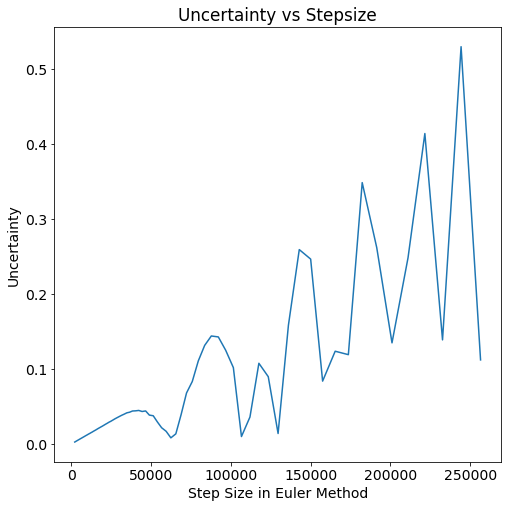

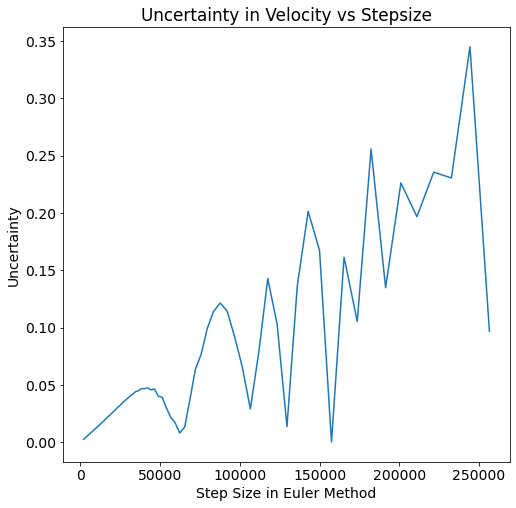

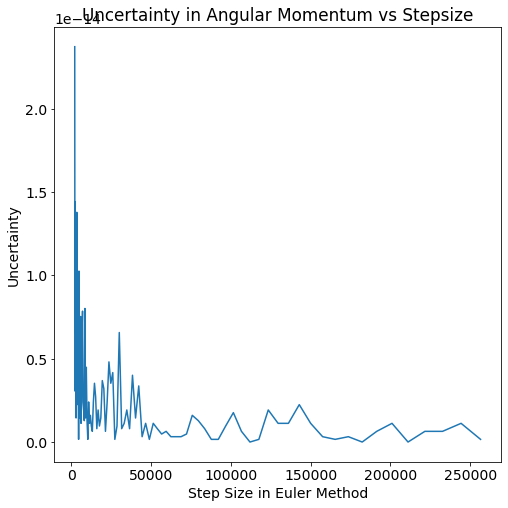

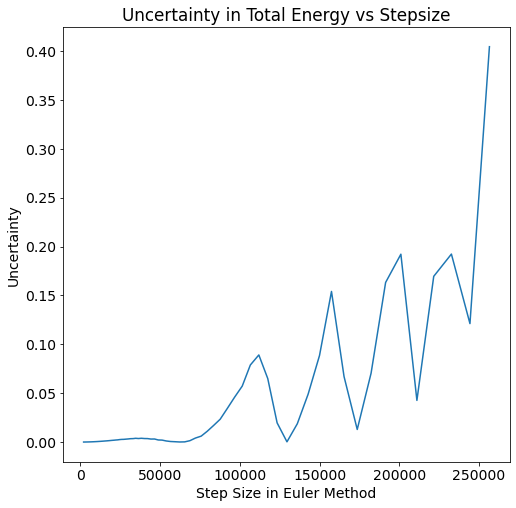

In [6]:
#Uncertainties

pos_unc = []
vel_unc = []
L_unc = []
E_unc = []
all_steps = []


for j in range(len(errors)):
    pos_unc.append(errors[j][0])
    vel_unc.append(errors[j][1])
    L_unc.append(errors[j][2])
    E_unc.append(errors[j][3])
    all_steps.append(errors[j][4])

plt.figure(figsize=(8, 8))
plt.plot(all_steps, pos_unc, label="Uncertainty in Position")
plt.title('Uncertainty vs Stepsize') #title
plt.xlabel('Step Size in Euler Method') #x label
plt.ylabel('Uncertainty') #y label
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(all_steps, vel_unc, label="Uncertainty in Velocity")
plt.title('Uncertainty in Velocity vs Stepsize') #title
plt.xlabel('Step Size in Euler Method') #x label
plt.ylabel('Uncertainty') #y label
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(all_steps, L_unc, label="Uncertainty in Angular Momentum")
plt.title('Uncertainty in Angular Momentum vs Stepsize') #title
plt.xlabel('Step Size in Euler Method') #x label
plt.ylabel('Uncertainty') #y label
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(all_steps, E_unc, label="Uncertainty in Total Energy")
plt.title('Uncertainty in Total Energy vs Stepsize') #title
plt.xlabel('Step Size in Euler Method') #x label
plt.ylabel('Uncertainty') #y label
plt.show()

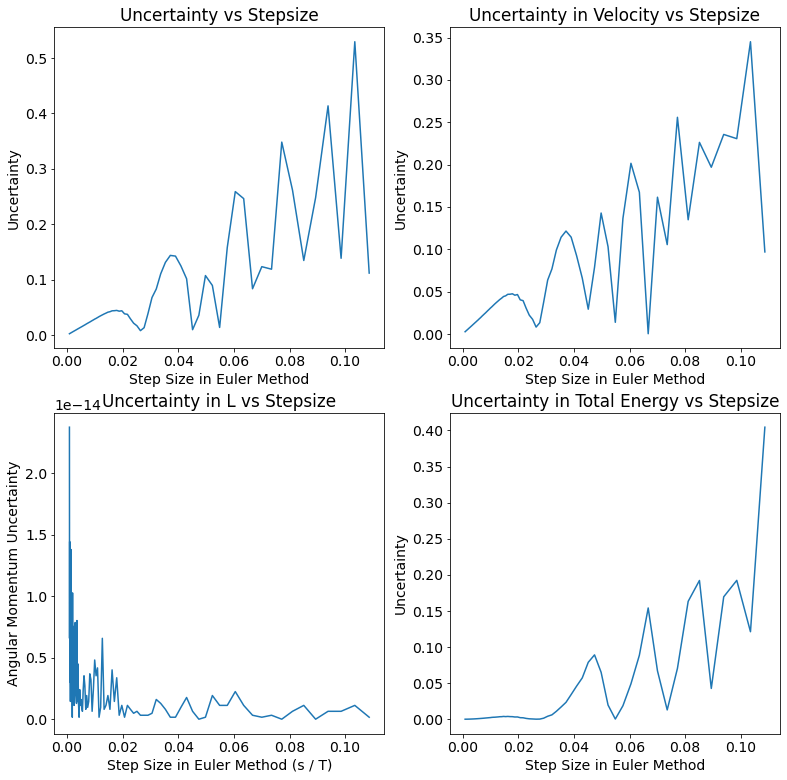

In [7]:
T = 2360620.8 #orbital period of moon

#print(len(L_unc))
LL = []
#edited = []

LL = L_unc.copy()
#edited = all_steps.copy()

#k = 15
#n = len(LL)
#for i in range(0, n - k ):
#    LL.pop()
#    edited.pop()

#print(LL)

#all_steps = np.array(all_steps) / T

scaled_steps = np.array(all_steps.copy()) / T

#print(scaled_steps)

#plt.figure(figsize=(8, 8))
#plt.plot(edited, LL, label="Uncertainty in Angular Momentu")
#plt.title('Uncertainty in Angular Momentum vs Stepsize') #title
#plt.xlabel('Step Size in Euler Method') #x label
#plt.ylabel('Uncertainty') #y label
#plt.show()

fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(scaled_steps, pos_unc, label="Uncertainty in Position")
ax1.set_title('Uncertainty vs Stepsize') #title
ax1.set_xlabel('Step Size in Euler Method') #x label
ax1.set_ylabel('Uncertainty') #y label

ax2.plot(scaled_steps, vel_unc, label="Uncertainty in Velocity")
ax2.set_title('Uncertainty in Velocity vs Stepsize') #title
ax2.set_xlabel('Step Size in Euler Method') #x label
ax2.set_ylabel('Uncertainty') #y label

ax3.plot(scaled_steps, LL, label="Uncertainty in Angular Momentum")
ax3.set_title('Uncertainty in L vs Stepsize') #title
ax3.set_xlabel('Step Size in Euler Method (s / T)') #x label
ax3.set_ylabel('Angular Momentum Uncertainty') #y label

ax4.plot(scaled_steps, E_unc, label="Uncertainty in Total Energy")
ax4.set_title('Uncertainty in Total Energy vs Stepsize') #title
ax4.set_xlabel('Step Size in Euler Method') #x label
ax4.set_ylabel('Uncertainty') #y label
plt.show()

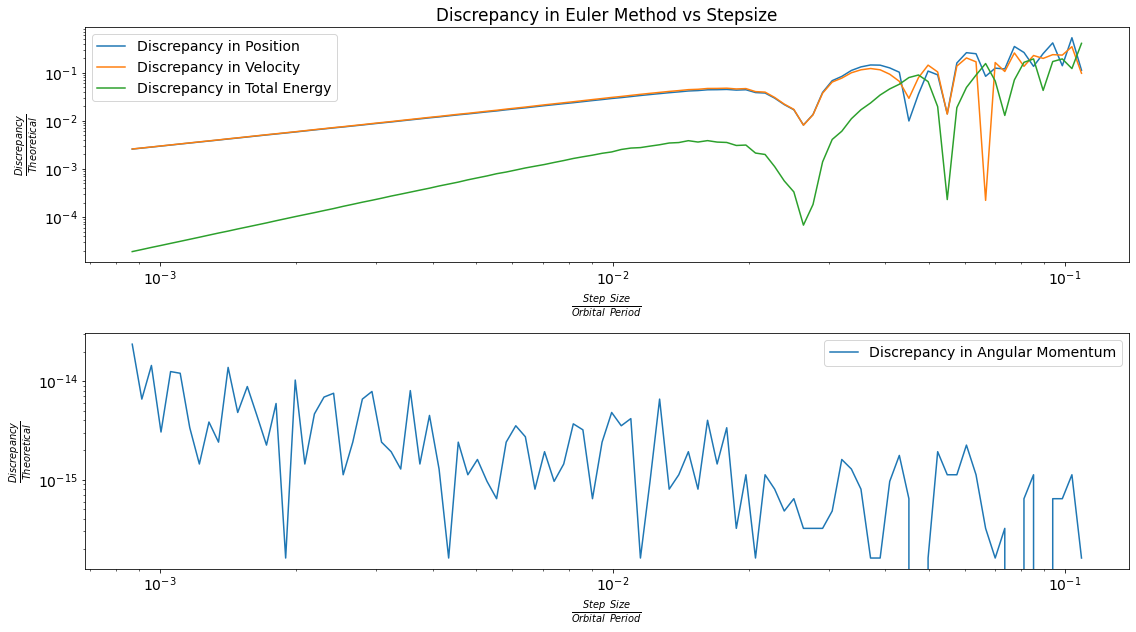

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.loglog(scaled_steps, pos_unc, label="Discrepancy in Position")
ax1.set_title('Discrepancy in Euler Method vs Stepsize') #title
#ax1.set_xlabel('Step Size in Euler Method') #x label
#ax1.set_ylabel('Uncertainty') #y label

ax1.loglog(scaled_steps, vel_unc, label="Discrepancy in Velocity")

ax1.loglog(scaled_steps, E_unc, label="Discrepancy in Total Energy")

ax2 = fig.add_subplot(2,1,2)
ax2.loglog(scaled_steps, LL, label="Discrepancy in Angular Momentum")
for ax in [ax1,ax2]:
    ax.set_xlabel(r'$\frac{Step \hspace{0.5} Size}{Orbital  \hspace{0.5} Period}$') #x label
    ax.set_ylabel(r'$\frac{Discrepancy}{Theoretical}$') #y label
    ax.legend()

fig.tight_layout()
plt.show()
fig.savefig("Discrepancies5Prototype.png")